### Moscot tutorial 

#### Imports and data loading

In [1]:
import warnings

from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import moscot as mt
from moscot import datasets
from moscot.problems.space import MappingProblem

import numpy as np

import seaborn as sns

import scanpy as sc

In [2]:
adata_sc = datasets.drosophila(spatial=False)
adata_sp = datasets.drosophila(spatial=True)
adata_sc, adata_sp

100%|██████████| 16.1M/16.1M [00:00<00:00, 29.5MB/s]
100%|██████████| 2.21M/2.21M [00:00<00:00, 10.4MB/s]


(AnnData object with n_obs × n_vars = 1297 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 3039 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

#### cluster the data 

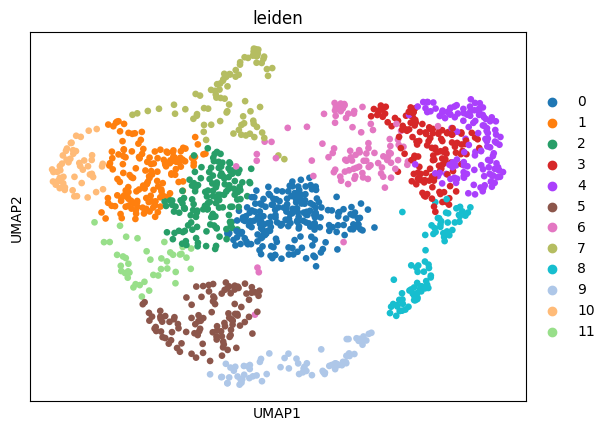

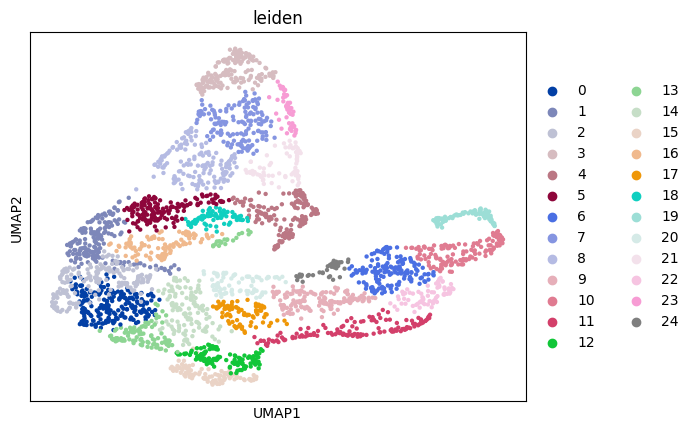

In [3]:
sc.pp.neighbors(adata_sc)
sc.pp.neighbors(adata_sp)

sc.tl.umap(adata_sc)
sc.tl.umap(adata_sp)

sc.tl.leiden(adata_sc)
sc.tl.leiden(adata_sp)
adata_sc.obs.leiden = adata_sc.obs.leiden.astype("category")
adata_sp.obs.leiden = adata_sp.obs.leiden.astype("category")

sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color="leiden")

#### prepare and solve the problem

In [4]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

In [5]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
).solve()

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          


CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


#### Create the annotation mapping of leiden clusters

In [6]:
anno_map_max = mp.annotation_mapping(
    "max",
    "leiden",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp.obs["leiden_max"] = anno_map_max["leiden"].values
adata_sp.obs["leiden_max"] = adata_sp.obs["leiden_max"].astype("category")

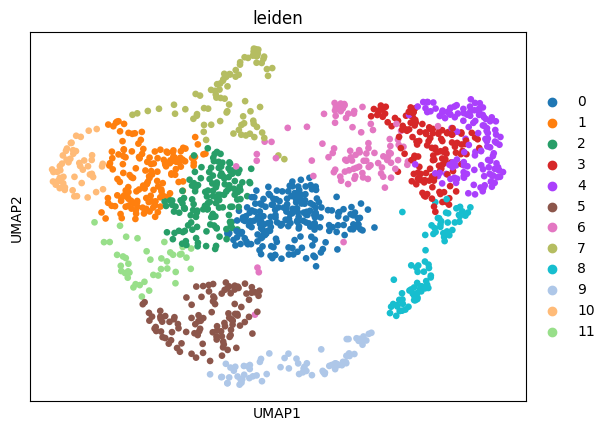

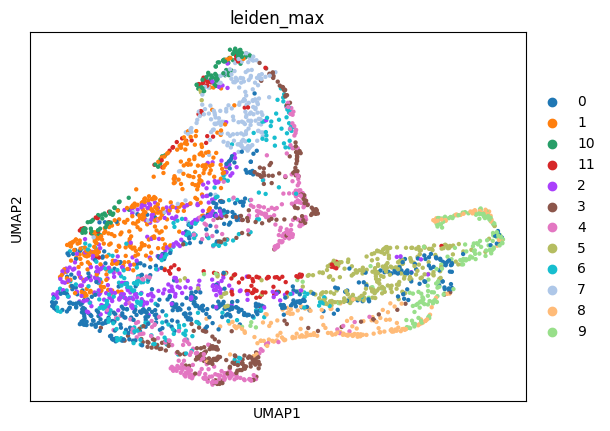

In [7]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden_max"])

In [8]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "leiden",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp.obs["leiden_sum"] = anno_map_sum["leiden"].values
adata_sp.obs["leiden_sum"] = adata_sp.obs["leiden_sum"].astype("category")

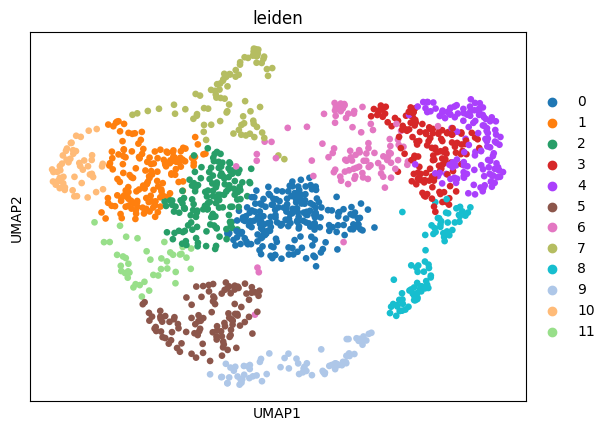

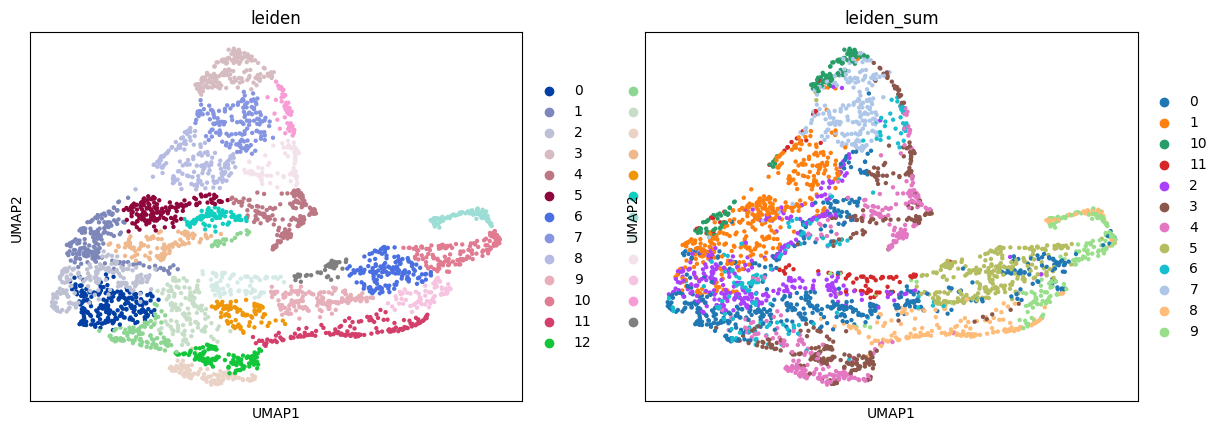

In [9]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden", "leiden_sum"])

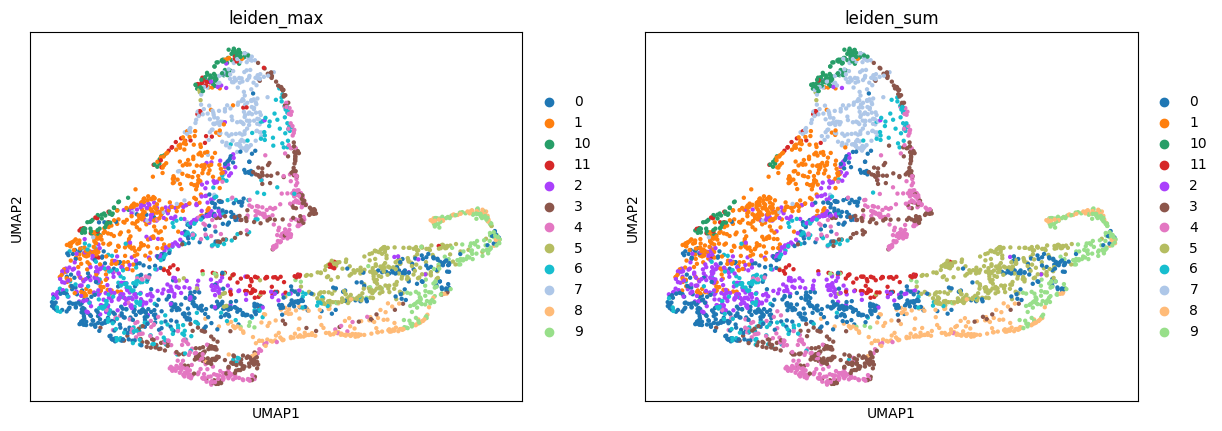

In [10]:
sc.pl.umap(adata_sp, color=["leiden_max", "leiden_sum"])

In [11]:
adata_sp[adata_sp.obs["leiden_max"] == adata_sp.obs["leiden_sum"]].shape[
    0
] / adata_sp.shape[0]

0.8644290885159592